## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

shared/problem1-reg_data.csv – данные о времени регистрации

shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

По общему комментарию ревьюера: оставляем рабочую часть, "шелуху" убираем

In [1]:
import pandas as pd
import time
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

def retention(reg_data_file, auth_data_file, first_coh_date, last_coh_date, ret_day):
    '''
    Функция считает retention игроков (по дням от даты регистрации игрока). На вход ей нужны: 
        1) путь к файлу регистраций 
        2) путь к файлу аутентификаций 
        3) дата регистрации для первой когорты из периода 
        4) дата регистрации для последней когорты из периода
        5) период ретеншна (кол-во дней, на который строить график ретеншена)
    '''

    start = time.time()
    
    # по 1 комментарию ревьюера настраиваю функцию так, чтобы она могла читать исходные файлы
    # то бишь меняю аргументы функции с датафрейма на путь к файлу
    # время работы функции возрастет, но не шибко
    
    df_reg_data = pd.read_csv(reg_data_file, sep=';')
    df_auth_data = pd.read_csv(auth_data_file, sep=';')
    
    end = time.time()
    print(f'Загружены файлы за {(end - start):.2f} сек.')
    
  
    
    
    if first_coh_date > last_coh_date:
        print('Дата регистрации позднее даты аутентификации, проверьте даты.')
    else:
        
        print('Даты корректны')

        
        # по 2 комментарию ревьюера, для ускорения времени работы функции 
        # сразу уменьшим датафреймы, отфильтровав их по дате
        # изначально функция работала ~60 сек
        # с доработкой функции и удаления "шелухи" время сократилось до ~6 сек
        # перевод даты в timestamp должен учитывать UTC 
        # по 3 комментарию ревьюера, разделяю периоды формирования когорт от периода ретеншена       
        
        s_reg_ts = datetime.strptime(first_coh_date, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp()
        f_reg_ts = datetime.strptime(last_coh_date, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp()
        f_auth_ts = f_reg_ts + ret_day*24*60*60
        
        df_reg_data_f = df_reg_data \
            .query('reg_ts >= @s_reg_ts & reg_ts <= @f_reg_ts')
        
        df_auth_data_f = df_auth_data \
            .query('auth_ts >= @s_reg_ts & auth_ts <= @f_auth_ts')
        
        #переводим даты в дф в человеческий вид
        df_reg_data_f['reg_ts'] = pd.to_datetime(df_reg_data_f['reg_ts'], unit='s').dt.floor('D').dt.date
        df_auth_data_f['auth_ts'] = pd.to_datetime(df_auth_data_f['auth_ts'], unit='s').dt.floor('D').dt.date

        #мержим таблицы регистрации и авторизации
        print('Мержим таблицы')
    
        df_merged = df_reg_data_f \
                        .merge(df_auth_data_f, on='uid', how='left') \
                        .rename(columns={'reg_ts':'reg_day','auth_ts':'auth_day'})
        
        #теперь фильтруем таблицу по датам: 
        #оставляем от интересующей даты регистрации до интересующей даты авторизации
        first_coh_date = datetime.strptime(first_coh_date, '%Y-%m-%d').date()
        last_coh_date = datetime.strptime(last_coh_date, '%Y-%m-%d').date()
        
#         этот фильтр не нужен и не корректен, т.к. мы теперь фильтруем сразу после загрузки дф 
#         df_merged_filtered = df_merged.query('reg_day >= @first_coh_date and auth_day <= @last_coh_date')
        df_merged_filtered = df_merged
        
        
        #считаем дни от регистрации до авторизации
        print("Считаем дни")
        
        df_merged_filtered['auth_x_days_after_reg'] = (df_merged_filtered.auth_day - df_merged_filtered.reg_day).dt.days
        # до какого дня смотреть ретеншн
        df_merged_filtered = df_merged_filtered.query('auth_x_days_after_reg <= @ret_day ')
        end = time.time()        
        
        #группируем, готовим когорты
        print('Создаем когорты')

        df_merged_grouped = df_merged_filtered \
                                .groupby(['reg_day', 'auth_x_days_after_reg'], as_index = False) \
                                .agg({'uid':'nunique'})

        cohort = df_merged_grouped \
            .pivot(index='reg_day', columns='auth_x_days_after_reg', values='uid')

        #нормируем по размеру когорты
        post_cohort = cohort.divide(cohort[0], axis=0).round(4)

        #первая колонка = размеру когорты
        post_cohort[0] = cohort[0].astype(int)
        post_cohort = post_cohort.rename(columns={0: 'Размер когорты'})

        end = time.time()
        
        #########
        # в целом функция готова и выдает ретеншн, но для удобства рисуем хитмап
        
        # создаем формат аннотации для хитмапа 
        heatmap_format = post_cohort.copy()
        heatmap_format['Размер когорты'] = heatmap_format['Размер когорты'].apply(lambda x: '{:.0f}'.format(x))
        for col in heatmap_format.columns[1:]:
            heatmap_format[col] = heatmap_format[col].apply(lambda x: '{:.2%}'.format(x))
    
        # настройка хитмапа
        sns.set (
            font_scale=1,
            style="whitegrid",
            rc={'figure.figsize':(32,18)},
                )
        
        fig, ax = plt.subplots()
        ax.set_title(f'Ретеншен от регистрации до захода в игру, когорты с {first_coh_date} по {last_coh_date}',
                     fontsize=32, weight='bold')
        sns.heatmap(post_cohort, vmin=0, vmax=0.1, annot=heatmap_format, fmt='',linewidths=0.5)
        ax.set_xlabel('Retention на Х день', fontsize=24)
        ax.set_ylabel('Дата регистрации', fontsize=24)
        
        end = time.time()
        print(f'Выполнено за {(end - start):.2f} сек.')
        
    return retention

In [3]:
print(retention.__doc__)


    Функция считает retention игроков (по дням от даты регистрации игрока). На вход ей нужны: 
        1) путь к файлу регистраций 
        2) путь к файлу аутентификаций 
        3) дата регистрации для первой когорты из периода 
        4) дата регистрации для последней когорты из периода
        5) период ретеншна (кол-во дней, на который строить график ретеншена)
    


Загружены файлы за 2.47 сек.
Даты корректны


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Мержим таблицы
Считаем дни
Создаем когорты
Выполнено за 11.62 сек.


<function __main__.retention(reg_data_file, auth_data_file, first_coh_date, last_coh_date, ret_day)>

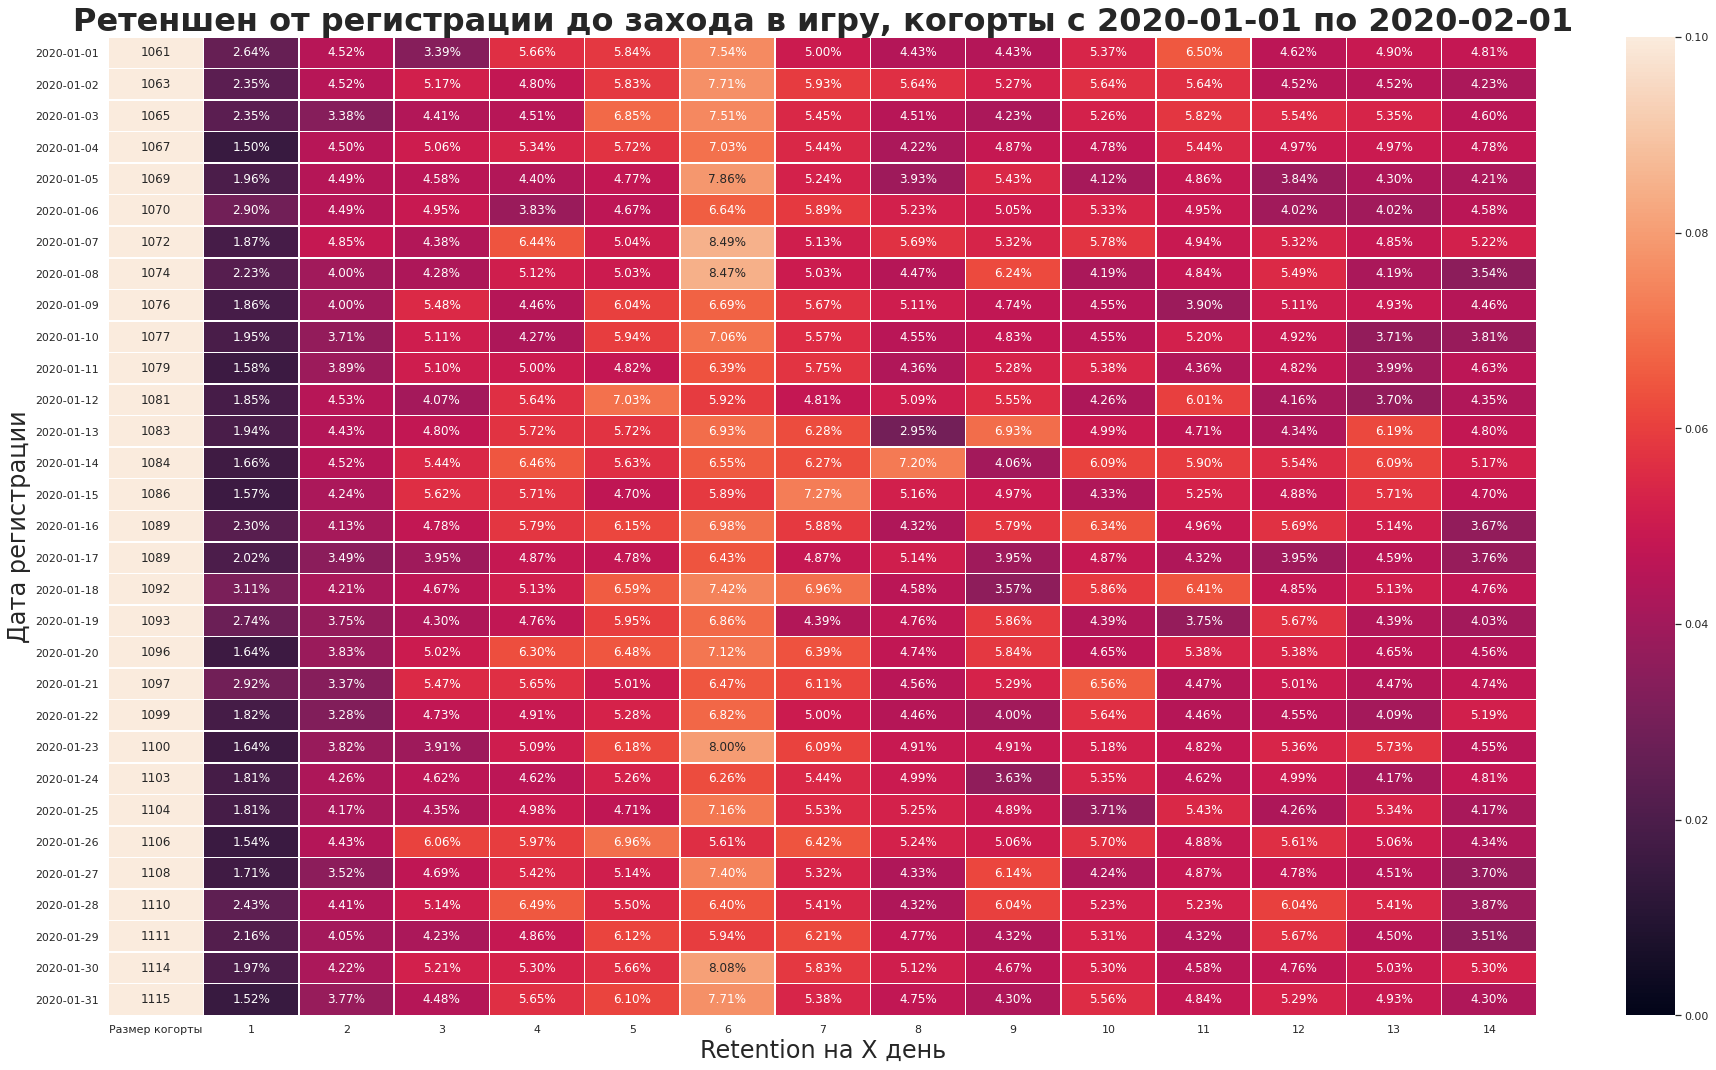

In [4]:
reg_data_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-sarkisian/shared/problem1-reg_data.csv'
auth_data_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-sarkisian/shared/problem1-auth_data.csv'

retention(reg_data_file, auth_data_file, '2020-01-01', '2020-02-01', 14)
